# Model training

## 1. Data pre-processing

We load the dataset locally as an Excel file (xlsx), and add a column that encodes the category as an integer as categorical variables are often better represented by integers than strings.

In [1]:
import pandas as pd

In [2]:
# Import "Noticias_Excel.xlsx" or else it wont be able to read it on the next block
from google.colab import files
uploaded = files.upload() 


Saving Noticias_Excel.xlsx to Noticias_Excel.xlsx


In [3]:
from io import StringIO 
df = pd.read_excel('Noticias_Excel.xlsx') 
# We add a 'category_id' column useful for later operations such as building the confusion matrix
# 0 --> Despoblacion, 1 --> No Despoblacion where 'Despoblacion' = Empty Spain & 'No Despoblacion' = any other topic (finance, business etc.)
df['category_id'] = df['Category'].factorize()[0] 

In [4]:
# Remove duplicates and sort by category_id
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id') 
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

## 2. Data exploration

Before delving into machine learning model training, we must familiarize ourselves with the structure and characteristics of our dataset.

We will first show a series of random examples and their structure:

In [5]:
df.sample(5, random_state=0)

,Titulo,Entradilla,Cuerpo,FechaPublicacion,Keywords,URL,Category,category_id
7,"Trasvase y despoblación: Castilla-La Mancha, l...",Las interesantes reflexiones de Miguel Ángel S...,Miguel Ángel Sánchez es técnico de la Asociaci...,2020-06-30T21:05:00+02:00,"Emisoras, Castilla la Mancha",https://www.cope.es/emisoras/castilla-la-manch...,Despoblacion,0
24,Día del Soltero 2020: Estos son los cupones de...,Aliexpress ofrece una serie de cupones descuen...,"El Día del Soltero 2020 ha llegado, y Aliexpre...",2020-11-11T14:00:07.091+01:00,"""Día del Soltero"",""descuento"",""AliExpress""",https://www.antena3.com/noticias/tecnologia/di...,No Despoblacion,1
27,Cardassar y Marchamalo se clasifican en penalt...,"Además, el CD Rincón, Racing Murcia, Anaitasun...",Este miércoles se ha disputado la eliminatoria...,2020-11-11T23:33:00+01:00,"Deportes"",""Fútbol",https://www.cope.es/deportes/futbol/noticias/c...,No Despoblacion,1
119,Cinco buenas noticias de este sábado para venc...,NaN,"No se podrá administrar hasta el próximo año, ...",18/04/2020 - 8:15,NaN,NaN,Despoblacion,0
142,Celta y Eibar suman sin alardes,"El equipo gallego, todavía sin Aspas, se adela...","Sumaron Celta y Eibar, que pueden ver la resol...",2021-01-24 - 19:44:20.178,NaN,NaN,No Despoblacion,1


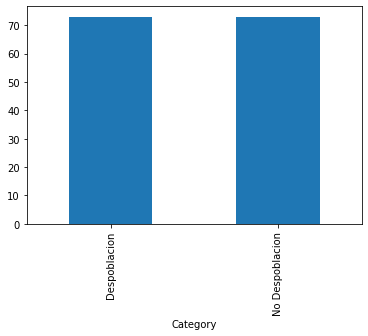

In [6]:
# We check if the data is balanced (in our case it is, perfect!)
df.groupby('Category').Category.count().plot.bar(ylim=0)

Here, we see that the number of items per class is balanced, which is helpful! If our dataset were unbalanced, we would need to carefully configure our model or artificially balance the dataset, for example, [undersampling or oversampling] in each class.

To further analyze our data set, we must transform the text of each article into a feature vector, a list of numerical values ​​that represent some of the features in the text. This is because most ML models cannot process plain text, but only deal with numeric values.

A common approach to extracting characteristics from text is to use the bag of words model: a model in which for each document, an article in our case, the presence (and often the frequency) of the words is taken into account, but the order in which they occur is ignored.

Specifically, for each term in our data set, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated as tf-idf. This statistic represents the importance of the words in each document. We use the frequency of a word as a proxy for its importance: if "depopulation" is mentioned 25 times in a document, it could be more important than if it is mentioned only once. We also use document frequency (the number of documents that contain a given word) as a measure of how common the word is. This minimizes the effect of stop words like pronouns or domain-specific language that doesn't add much information (for example, a word like "news" that might be present in most documents).

We will be using sklearn (aka scikit-learn), a machine learning library that is particularly accessible for beginners.
We use the `TfidfVectorizer` class to calculate a` tf-idf` vector for each of our documents:

`sklearn.feature_extraction.text.TfidfVectorizer` will be used to calculate a vector` tf-idf` for each of our documents. The following parameters are passed to this class:

- `sublinear_df` is set to` True` to use a logarithmic form of frequency, to give diminishing returns as the frequency of a word increases. This is usually preferable for a number of reasons, one of which is [Zipf's Law] (https://en.wikipedia.org/wiki/Zipf%27s_law).
- `min_df` is the minimum number of documents in which a word must be present to be preserved, and we are setting it to` 5`. This is to avoid weird words, which drastically increase the size of our functions and can cause [overfitting] (https://en.wikipedia.org/wiki/Overfitting).
- `norm` is set to` l2`, to ensure that all our feature vectors have a Euclidean norm of 1. This is useful for visualizing these vectors and may also improve (or deteriorate) the performance of some models.
- `encoding` is set to` utf-8`, which is used by our input text.
- `ngram_range` is set to` (1, 2)` to indicate that we want to consider both unigrams and bigramas, or in other terms: we want to consider simple words ("spain", "town") and pairs of words ("empty spain "," empty towns ").
- Finally, `stop_words` is passed a file to remove all common pronouns (" a "," some "," en "," the "...) and further reduce the number of noisy features.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords_list = [word for word in stopwords.words('spanish')]

#TF-IDF lo vectoriza para saber la similitud de palabras, hace un podado de menos de 5 palabras no las tiene en cuenta, ngram junta palabras, stop words en español)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words=stopwords_list)
features = tfidf.fit_transform(df.Cuerpo).toarray()
labels = df.category_id
features.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(146, 849)

Each of our 146 documents is now represented by 849 features, representing the tf-idf score for different unigrams and bigrams.

This representation is useful not only to solve our classification task, but also to become familiar with the data set. For example, we can use the chi-square test to find the terms that are most correlated with each of the categories:

In [8]:
# NOTE: chi2 test doesn't work very well with only two categories hence the results

from sklearn.feature_selection import chi2
import numpy as np

# Select 5 most correlated unigrams and bigrams
N = 5
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


# 'Despoblacion':
  . Most correlated unigrams:
       . despoblación
       . rurales
       . vaciada
       . zonas
       . pueblos
  . Most correlated bigrams:
       . kilómetro cuadrado
       . medio rural
       . banda ancha
       . zonas rurales
       . españa vaciada
# 'No Despoblacion':
  . Most correlated unigrams:
       . despoblación
       . rurales
       . vaciada
       . zonas
       . pueblos
  . Most correlated bigrams:
       . kilómetro cuadrado
       . medio rural
       . banda ancha
       . zonas rurales
       . españa vaciada


Although this first test demonstrates the presence of specific terms for each category, there may still be too much noise in the data, making it impossible to clearly separate each category. One way to confirm that the feature space we are using is representative enough that our task (sorting items into separate labels) can be solved is to use dimensionality reduction techniques.

Since our dataset contains natural language we will use t-SNE, a popular dimensionality reduction technique used in many fields, including NLP.

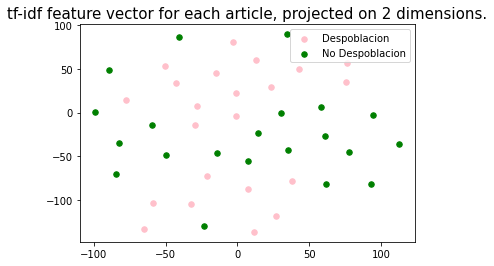

In [9]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for Category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=Category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

Because our news set does not have so many documents, in this graph it is not possible to see the clarity of the separation of "Depopulation" and "No Depopulation" categories. If more data were added, it could be clearly seen that the news of one category are grouped in one place and those of the other category in another, achieving better performance. Of course, there could be some outlier which are points from one category that are in the middle of a different category.

In [10]:
# We check which articles contain the world 'town' in its body
df[df.Cuerpo.str.contains('pueblo')]

,Titulo,Entradilla,Cuerpo,FechaPublicacion,Keywords,URL,Category,category_id
0,¿Ayudaría a la España vaciada un Ministerio pa...,Los vecinos de la España vaciada han explicado...,Los vecinos de la España vaciada reclaman la n...,2019-11-16T19:13:16.219+01:00,"España despoblada, España Vaciada, video",https://www.antena3.com/noticias/sociedad/ayud...,Despoblacion,0
1,La España vaciada frena la despoblación gracia...,Hispana Nostra es la única plataforma que divu...,"En la España vaciada, cualquier estrategia es ...",2020-01-11T19:33:16.758+01:00,"video, España vaciada, arte",https://www.antena3.com/noticias/sociedad/la-e...,Despoblacion,0
2,Zamora es la provincia española que más ha suf...,Acceder a los servicios sanitarios no siempre ...,La diputación provincial de Soria ha decidido ...,2020-01-12T16:48:17.532+01:00,"video, Navalacruz' Centro Medico' Zamora' desp...",https://www.antena3.com/noticias/sociedad/zamo...,Despoblacion,0
3,España vacía: Buscan en Soria camareros para f...,La diputación provincial de Soria ha decidido ...,La diputación provincial de Soria ha decidido ...,2020-01-28T14:13:49.179+01:00,"Camareros, soria",https://www.antena3.com/noticias/economia/se-b...,Despoblacion,0
4,La España vacía se queda sin cuarteles de la G...,En España hay 2300 cuarteles y mantenerlos es ...,La España vacía se queda también sin cuarteles...,2020-01-21T18:51:56.854+01:00,"Guardia Civil, cuarteles, españa vacia",https://www.antena3.com/noticias/sociedad/la-e...,Despoblacion,0
5,Cinco iniciativas que buscan repoblar la Españ...,"La vivienda, el reparto a domicilio o las nuev...",En tiempos en los que la masificación y el tra...,2020-03-28T02:10:00+01:00,"pueblos, actualidad, pueblo, planes, la españa...",https://www.cope.es/actualidad/sociedad/espana...,Despoblacion,0
6,La despoblación en España vista desde un puebl...,En La Noche de COPE conocemos más a fondo cómo...,A veces la tierra natal es hostil para encontr...,2019-03-12T10:48:00+01:00,"Actualidad, Pueblo, Ciudades, Programas, la no...",https://www.cope.es/programas/la-noche/audios/...,Despoblacion,0
7,"Trasvase y despoblación: Castilla-La Mancha, l...",Las interesantes reflexiones de Miguel Ángel S...,Miguel Ángel Sánchez es técnico de la Asociaci...,2020-06-30T21:05:00+02:00,"Emisoras, Castilla la Mancha",https://www.cope.es/emisoras/castilla-la-manch...,Despoblacion,0
8,Despoblación: la lucha de la España Vaciada,Te presentamos gente que nos cuenta sus proble...,No es raro que las personas que viven en los p...,2020-03-02T21:11:00+01:00,"Programas, La Linterna, El tema del dia",https://www.cope.es/programas/la-linterna/el-t...,Despoblacion,0
9,Pueblos Vivos Jacetania proyecta nuevas accion...,"Entre ellas, el ciclo de formación y dinamizac...",El proyecto Pueblos Vivos Jacetania ha iniciad...,2020-10-19T12:45:00+02:00,"Emisoras, Aragon, Huesca provincia, Jaca, La M...",https://www.cope.es/emisoras/aragon/huesca-pro...,Despoblacion,0


As we can see in the * news item 52 or 145 *, it deals with "No Depopulation" although the word "town" is used and in most cases this news is classified as "Depopulation", so this news is an atypical value.


## 3. Model training and evaluation

### **Metric**

Since we are dealing with a news classification task and since it is a balanced dataset we will use the precision (accuracy) metric.

### **Model selection**

- **Logistic Regression**: A linear classifier, mostly similar to traditional linear regression, but fitting the output of the logistic function.

- **(Multinomial) Naive Bayes**: A Bayesian model, assuming full independence between features, which works surprisingly well with the Bag of Words model, and was used primarily for spam detection.

- **Random Forest**: Is the set of a large number of decision trees, each one trained in a random subset of the input characteristics. They work well when it comes to complex feature relationships and are relatively resistant to overfitting.

- **SVC**: Are a set of supervised learning methods used for classification, regression and detection of outliers. The advantages of SVM are that they are effective in large spaces. It is still effective in cases where the number of dimensions is greater than the number of samples.

- **KNeighborsClassifier**: The K Neighbors algorithm is a non-parametric machine learning method. It is used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space.


### **Model evaluation**

We will divide the dataset into two sets:

- A training set in which the model will be trained.
- A validation set to obtain the precision of the model.

To evaluate each model, we will use the K-fold cross validation technique, with 10 folds so that we obtain 10% (1 fold) of the data for validation and 90% (9 folds) of the data for training: training iteratively the model on different subsets of data and testing against the obtained data to avoid common problems such as "overfitting" (the model performs well in the training set but achieves poor results in the validation set) and "underfitting" (the model gets very poor results in the validation set and usually also in the training set).

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(),
    KNeighborsClassifier(),
]
# 10 folds
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

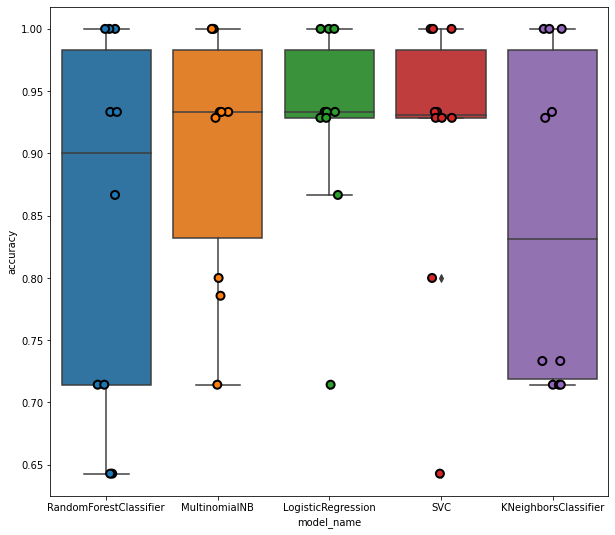

In [12]:
# Plot box diagram to see the accuracy and variance of the models
import seaborn as sns

fig_dims = (10, 9) #x, y
fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="black", linewidth=2)

In [13]:
# Obtain the best accuracy model (we also observe its variance above to check if its the best)
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.847143
LogisticRegression        0.923810
MultinomialNB             0.902857
RandomForestClassifier    0.844762
SVC                       0.909524
Name: accuracy, dtype: float64

The results of the RandomForest and K-Neighbors model show a large variance, a sign that we are facing an "overfitting" problem. We also observed that the best model is LogisticRegression with a precision of 92.4% and a small variance, followed by SVC with a precision of 91% and MultinomialNB (Naive Bayes) with a precision of 90.3% and a variance greater than the previous ones.

### 4. Model interpretation

Now that we have the best model, looking deeper into the model interpretation we also observe the confusion matrix to see how many true false (among other things) our model predicts: where each column of the matrix represents the number of predictions of each class, while each row represents the true cases of class.

In [14]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

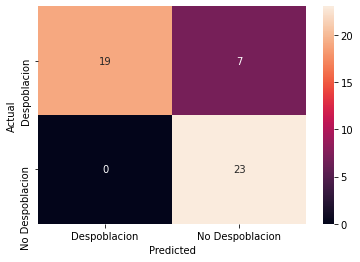

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#30% test

We analyze in greater detail the "true false" for the Depopulation class to check what is causing these failures:

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Titulo', 'Cuerpo']])
      print('')

'Despoblacion' predicted as 'No Despoblacion' : 7 examples.


,Titulo,Cuerpo
119,Cinco buenas noticias de este sábado para venc...,"No se podrá administrar hasta el próximo año, ..."
37,Los principales retos de la prensa local ante ...,Todos los gurús de la prensa llevan mucho tiem...
116,Castilla y León registra el segundo peor saldo...,La cifra de nacimientos en Castilla y León des...
84,"""El olvido de la minería convierte a Asturias ...",El Gobierno ha dejado claro esta semana que la...
83,"""Teruel Existe, rumbo al 10-N: &quot;Resulta q...",El paso al frente de la plataforma Teruel Exis...
105,"Pedro Gallardo: ""Defenderé la agricultura como...","El vicepresidente de ASAJA, Pedro Gallardo ha ..."
122,"Así es la sierra norte de Guadalajara, el luga...","En Campisabalos, en el extremo noroccidental d..."


As it can be seen above, erroneously classified articles are articles that speak of different topics (articles that involve words related to Depopulation, such as those that speak of towns in Spain). It should be noted that a model with a maximum accuracy of 100% is an unrealistic case as there are always model failures due to this.

Subsequently, we verify that terms are associated more frequently with the different classes (Depopulation and Non-Depopulation) using the chi-square technique to obtain the unigrams and bigrams:

In [16]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'Despoblacion':
  . Top unigrams:
       . después
       . tras
       . partido
       . semana
       . equipo
  . Top bigrams:
       . fin semana
       . año pasado
       . covid 19
       . 00 horas
       . 100 000
# 'No Despoblacion':
  . Top unigrams:
       . después
       . tras
       . partido
       . semana
       . equipo
  . Top bigrams:
       . fin semana
       . año pasado
       . covid 19
       . 00 horas
       . 100 000


In [18]:
# We check how many articles contain the word "Spain" in its title
df[df.Titulo.str.lower().str.contains('españa')].Category.value_counts()

Despoblacion       39
No Despoblacion     7
Name: Category, dtype: int64

### Test run

Next we will carry out a series of tests with some short texts on different topics to observe how the model categorizes them, it should be noted that in the example of the second sentence "* Once upon a time there was a very facherita Spain and I was one day with the boys doing things emptied * "by having a short length we obtain few characteristics in the TF-IDF vector and therefore keywords such as" Spain emptied "have more weight / importance hence the erroneous prediction, but we can verify that in a longer example this case is not given.

In [20]:
texts = ["España vaciada la situacion es muy mala",
         "Erase una vez una España bien facherita y estaba un dia con los boys haciendo cosas vaciada",
         "You won't guess what the latest trend in data analysis is!",
         "Ruben tambien porque juega al valorant La despoblación supone la pérdida total o parcial de los habitantes de un lugar como sandro",
         "Se tiene constancia de españa El contacto con la pelota se realiza con las manos. Los jugadores, también llamados baloncestistas, no pueden trasladarse sujetando la pelota, sino botándola contra el suelo. El equipo en posesión del balón o atacante, intenta anotar puntos mediante tiros, entradas a canasta vaciada o mates, mientras que el equipo defensor busca impedirlo robando la pelota o efectuando tapones. Cuando un tiro hacia la canasta fracasa, los jugadores de ambos equipos intentan atrapar el rebote. poblamiento en la deportes zona desde el Paleolítico Medio.  patata  Sin embargo, está discutido si la ciudad actual data de época visigoda o es anterior, aunque con total seguridad existía en el siglo xi, durante la dominación musulmana."
         ]

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

"España vaciada la situacion es muy mala"
  - Predicted as: 'Despoblacion'
"Erase una vez una España bien facherita y estaba un dia con los boys haciendo cosas vaciada"
  - Predicted as: 'Despoblacion'
"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'No Despoblacion'
"Ruben tambien porque juega al valorant La despoblación supone la pérdida total o parcial de los habitantes de un lugar como sandro"
  - Predicted as: 'Despoblacion'
"Se tiene constancia de españa El contacto con la pelota se realiza con las manos. Los jugadores, también llamados baloncestistas, no pueden trasladarse sujetando la pelota, sino botándola contra el suelo. El equipo en posesión del balón o atacante, intenta anotar puntos mediante tiros, entradas a canasta vaciada o mates, mientras que el equipo defensor busca impedirlo robando la pelota o efectuando tapones. Cuando un tiro hacia la canasta fracasa, los jugadores de ambos equipos intentan atrapar el rebote. poblamiento en la depor